# Dowdle's Wine Quality Prediction
**Author:** Brittany Dowdle
**Date:** April 8, 2025
**Objective:** Implement an ensemble model, combine multiple models to improve performance. Evaluate the model using performance metrics. Compare results and provide insights.

## Introduction
This project uses the Wine Quality dataset to predict red wines based on their physicochemical properties. Some features include acidities, sulfur dioxides, and sugars. I will train 2 models: . We are using ensemble models because they usually outperform individual models by reducing overfitting and improving generalization.

****

## Imports
In the code cell below, import the necessary Python libraries for this notebook. All imports should be at the top of the notebook.

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

****

## Section 1. Load and Inspect the Data
Load the Wine Quality dataset and confirm it’s structured correctly.

In [6]:
# Load the dataset (download from UCI and save in the same folder)
df = pd.read_csv("winequality-red.csv", sep=";")

# Display structure and first few rows
print('Info:')
print(df.info(), "\n")
print('First Few Rows:')
print(df.head())

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB
None 

First Few Rows:
   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4   

****

## Section 2. Prepare the Data
Includes cleaning, feature engineering, encoding, splitting, helper functions.

In [16]:
# Find duplicate rows
duplicate_rows = df[df.duplicated()]

# Print results
if not duplicate_rows.empty:
    print(f"Found {len(duplicate_rows)} duplicate rows!")
else:
    print("No duplicate rows found.")

Found 240 duplicate rows!


In [17]:
# Remove duplicate rows
df = df.drop_duplicates().reset_index(drop=True)
print(f"Duplicates removed. New dataset size: {df.shape}")

Duplicates removed. New dataset size: (1359, 14)


In [12]:
# Define helper function (Takes the quality and returns 3 categorical labels (low, medium, high))
def quality_to_label(q):
    if q <= 4:
        return "low"
    elif q <= 6:
        return "medium"
    else:
        return "high"
    
# Create the new column the helper function made
df["quality_label"] = df["quality"].apply(quality_to_label)

# Confirm the column
print("quality_label values:")
print(df["quality_label"].unique())

quality_label values:
['medium' 'high' 'low']


In [13]:
# Define helper function (Takes the qualiity and simplifies target into 3 categories (0 = low, 1 = medium, 2 = high))
def quality_to_number(q):
    if q <= 4:
        return 0
    elif q <= 6:
        return 1
    else:
        return 2

# Create the new column the helper function made
df["quality_numeric"] = df["quality"].apply(quality_to_number)

# Confirm the column
print("quality_numeric values:")
print(df["quality_numeric"].unique())

quality_numeric values:
[1 2 0]


### Reflection
Removing duplicate rows ensures that training and test sets are split correctly later in the project. Simplifying this data from a continuous score into categorized classes helps the data be more suitable for data exploration and visualizations. Having discrete categories enables the model to handle and predict the target variable more effectively.

****

## Section 3. Feature Selection and Justification
The target variable is quality (integer score from 0 to 10, rated by wine tasters). Drop this variable (all 3 columns) from features selection.

In [15]:
# Define input features (X) and target (y)
X = df.drop(columns=["quality", "quality_label", "quality_numeric"])  # Features
y = df["quality_numeric"]  # Target

# Confirm features
print("Features columns:", X.columns.tolist())

Features columns: ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']


### Reflection
I dropped the quality columns to prevent the model from learning directly from the target or any of its derivations. Instead, the model will use only the wine’s physicochemical properties as predictors. This setup ensures a clean separation between input features and target labels, and allows us to evalute the models performance compared to actual results later in the project.

****

## Section 4. Split the Data into Train and Test
Split the data into training and test sets using stratify to ensure class balance remains the same.

In [18]:
# Split data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=44, stratify=y)

# Show set sizes
print('Train size:', len(X_train))
print('Test size:', len(X_test))

Train size: 1279
Test size: 320


****
## Section 5.  Evaluate Model Performance (Choose 2)
- Random Forest (200, max_depth=10) - Adds more trees, but limits tree depth to reduce overfitting.
- Gradient Boosting (100) - Boosting approach using gradient descent.

In [19]:
# Prints performance metrics and appends them to a results list for later comparison
results = []

# Define helper function to evaluate and compare models
def evaluate_model(name, model, X_train, y_train, X_test, y_test, results):
    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    train_f1 = f1_score(y_train, y_train_pred, average="weighted")
    test_f1 = f1_score(y_test, y_test_pred, average="weighted")

    print(f"\n{name} Evaluation")
    print("Confusion Matrix (Test):")
    print(confusion_matrix(y_test, y_test_pred))
    print(f"Train Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}")
    print(f"Train F1 Score: {train_f1:.4f}, Test F1 Score: {test_f1:.4f}")

    results.append(
        {
            "Model": name,
            "Train Accuracy": train_acc,
            "Test Accuracy": test_acc,
            "Train F1": train_f1,
            "Test F1": test_f1,
        }
    )

In [21]:
# Create Random Forest (200, max depth=10) 
evaluate_model(
    "Random Forest (200, max_depth=10)",
    RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42),
    X_train,
    y_train,
    X_test,
    y_test,
    results,
)

# Create Gradient Boosting(100)
evaluate_model(
    "Gradient Boosting (100)",
    GradientBoostingClassifier(
        n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42
    ),
    X_train,
    y_train,
    X_test,
    y_test,
    results,
)


Random Forest (200, max_depth=10) Evaluation
Confusion Matrix (Test):
[[  0  13   0]
 [  0 259   5]
 [  0  26  17]]
Train Accuracy: 0.9734, Test Accuracy: 0.8625
Train F1 Score: 0.9722, Test F1 Score: 0.8307

Gradient Boosting (100) Evaluation
Confusion Matrix (Test):
[[  0  13   0]
 [  4 251   9]
 [  0  26  17]]
Train Accuracy: 0.9687, Test Accuracy: 0.8375
Train F1 Score: 0.9675, Test F1 Score: 0.8138


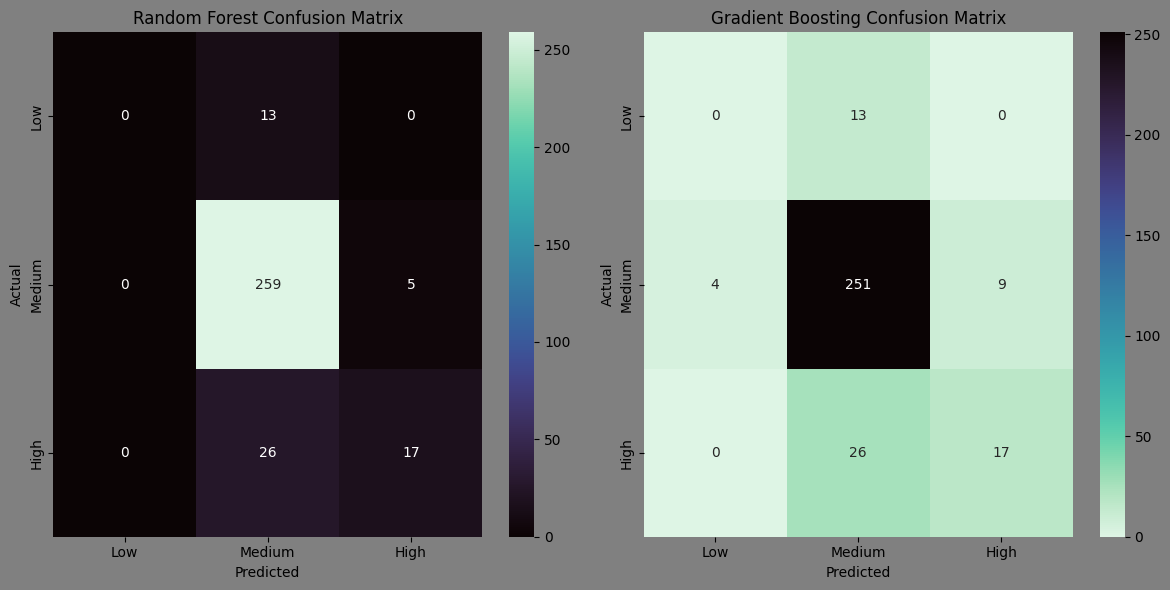

In [39]:
# Visualize the confusion matrices to compare models
# Capture the confusion matrices
rf_cm = confusion_matrix(y_test, RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42).fit(X_train, y_train).predict(X_test))
gb_cm = confusion_matrix(y_test, GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42).fit(X_train, y_train).predict(X_test))

# Create the figure
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
# Set the background color of the figure to light gray
fig.patch.set_facecolor('gray')

# Create plot for Random Forest
sns.heatmap(rf_cm, annot=True, fmt="d", cmap="mako", xticklabels=["Low", "Medium", "High"], yticklabels=["Low", "Medium", "High"], ax=axes[0])
axes[0].set_title("Random Forest Confusion Matrix")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

# Create plot for Gradient Boosting
sns.heatmap(gb_cm, annot=True, fmt="d", cmap="mako_r", xticklabels=["Low", "Medium", "High"], yticklabels=["Low", "Medium", "High"], ax=axes[1])
axes[1].set_title("Gradient Boosting Confusion Matrix")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")

# Display the figure
plt.tight_layout()
plt.show()

****